In [ ]:
#!pip install frc3223-azurite
#!pip install pynetworktables==2017.0.8
#!pip install pyfrc==2017.1.5

In [1]:
import numpy
import ctre

from hal_impl.data import hal_data
from matplotlib import pyplot as plt
from elevator import ElevatorSimulation
from frc3223_azurite import motors
from frc3223_azurite.conversions import *
from frc3223_azurite.pidcontroller import NoThreadingPIDController as PIDController
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, sim.xs)
    if ylim is None:
        ylim = (-sim.max_height_m * 0.1, sim.max_height_m * 1.1)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (m)')
    plt.show()
    
def plot_velocity(sim):
    m2ft = numpy.vectorize(meter_to_feet)
    plt.plot(sim.ts, m2ft(sim.vs))
    plt.ylim(0, 20)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (ft/s)')
    plt.show()

def plot_current(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.currents)
    plt.ylim(-sim.motor_system.motor.stall_current * 0.1, sim.motor_system.motor.stall_current * 0.8)
    plt.xlabel('time (s)')
    plt.ylabel('current (A)')
    plt.show()
    

width = inch_to_meter(4)
stage_x = numpy.array([0, 0, width, width, 0])
_stage_y = numpy.array([0, 1, 1, 0, 0])


def animate_lift(sim, frame_interval_ms=50, speed_factor=1):
    assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
    fig, ax = plt.subplots()
    stage_y = _stage_y * sim.max_height_m
    base_stage, stage_1, stage_2, carriage = plots = [ax.plot(stage_x, stage_y)[0] for i in range(4)]
    plt.ylim(0, (len(plots) * 2 + 0.1) * sim.max_height_m)
    dt = sim.ts[1]-sim.ts[0]
    n = int(frame_interval_ms / 1000. / dt) # number of data points to skip
    L = len(sim.ts) // n # number of data points sampled at 20 ms
    print (n, L, len(sim.ts))
    def init():
        return (line,)
    def animate(j): 
        i = j * n
        plots[1].set_ydata(stage_y + sim.xs[i])
        plots[2].set_ydata(stage_y + 2 * sim.xs[i])
        plots[3].set_ydata(stage_y * 0.3 + 3 * sim.xs[i])

        return plots


    anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval_ms / speed_factor, blit=True)
    return anim


def animate_climb(sim, frame_interval_ms=50, speed_factor=1):
    assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
    fig, ax = plt.subplots()
    stage_y = _stage_y * sim.max_height_m
    base_stage, stage_1, stage_2, carriage = plots = [
        ax.plot(stage_x, stage_y + i * sim.max_height_m)[0] for i in range(4)]
    plt.ylim(0, (len(plots) * 2 + 0.1) * sim.max_height_m)
    dt = sim.ts[1]-sim.ts[0]
    n = int(frame_interval_ms / 1000. / dt) # number of data points to skip
    L = len(sim.ts) // n # number of data points sampled at 20 ms
    print (n, L, len(sim.ts))
    def init():
        return (line,)
    def animate(j): 
        i = j * n
        plots[0].set_ydata(stage_y + sim.xs[i])
        plots[2].set_ydata(stage_y + 2 * sim.max_height_m - sim.xs[i])
        plots[3].set_ydata(stage_y * 0.3 + 3 * sim.max_height_m - 2 * sim.xs[i])

        return plots


    anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval_ms / speed_factor, blit=True)
    return anim


In [2]:
def init(state):
    import wpilib
    state.timer = wpilib.Timer()
    state.timer.start()
    state.motor.set(0.0)
    ctre.WPI_TalonSRX.Notifier = None
    talon = ctre.WPI_TalonSRX(1)
    
    talon.selectProfileSlot(0, 0)
    talon.configSelectedFeedbackSensor(talon.FeedbackDevice.QuadEncoder, 0, 0)
    talon.configMotionCruiseVelocity(int(3 * 4096 * 0.1), 0) # 1 rps
    talon.configMotionAcceleration(int(6 * 4096 * 0.1), 0) # 2 rps^2
    talon.configAllowableClosedloopError(0, 50, 0)
    talon.config_kP(0, 0.5, 0)
    talon.config_kI(0, .00, 0)
    talon.config_kD(0, 10, 0)
    state.talon = talon
    state.t1 = False
    
    state.talon.set(ctre.ControlMode.MotionMagic, int(inch_to_meter(30) / sim.sprocket_radius_m * 4096 / (2 * math.pi)))
    
def pid_periodic(state):
    enc_pos = int(state.x / sim.sprocket_radius_m * 4096 / (2 * math.pi))
    enc_vel = int(state.velocity_mps / sim.sprocket_radius_m * 4096 / (2 * math.pi))
    hal_data['CAN'][1]['quad_position'] = enc_pos
    hal_data['CAN'][1]['quad_velocity'] = enc_vel
    state.talon._calculate_1ms()
    state.motor.set(state.talon.hal_data['value'])
def periodic(state):
    #state.motor.set(1)
    
    if not state.t1 and state.timer.get() >= 4:
        state.t1 = True
        state.talon.set(ctre.ControlMode.MotionMagic, int(inch_to_meter(10) / sim.sprocket_radius_m * 4096 / (2 * math.pi)))
    pass


sim = ElevatorSimulation(
    starting_position_m=0,
    max_height_m=inch_to_meter(72),
    sprocket_radius_m=inch_to_meter(2),
    robot_mass_kg=lbs_to_kg(154),
    stage1_mass_kg=lbs_to_kg(20.0),
    stage2_mass_kg=lbs_to_kg(0.0),
    stage3_mass_kg=lbs_to_kg(0.0),
    stage1_counterweighting_n=lbs_to_N(.0),
    stage2_counterweighting_n=lbs_to_N(0.0),
    pulls_down = False,
    init=init,
    periodic=periodic,
    pid_periodic=pid_periodic,
    pid_sample_rate_s=0.001,
    gearbox_efficiency=0.65,
    motor_system=motors.MotorSystem(motor=motors._775pro, motor_count=2, gearing_ratio=30),
    dt_s=0.0001,
)

print ('stages: ', sim.stages_gravity())
print ('counterweight: ', sim.counterweighting())

stages:  88.99632
counterweight:  0.0


In [3]:
ms = motors.MotorSystem(motor=motors._775pro, motor_count=2, gearing_ratio=30)
radius = inch_to_meter(2.12)
stall_force = ms.stall_torque / radius * .65
print (stall_force)
fs = ms.free_speed * radius
print (fs )
ct = lbs_to_N(20) 
print (ct)
sp = fs * ( 1 - ct / stall_force)
print (sp)
ctf = ct * radius
print (ctf)
print (ms.motor_current_at_torque(ctf))
t2 = ctf / 50 / 2 / 0.65
print(t2 )

514.2252265636606
3.5205840589696944
88.96000000000001
2.9115296180219765
4.7903180800000005
15.068136683568076
0.07369720123076924


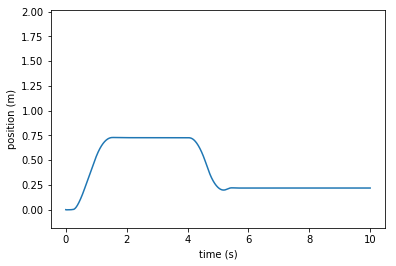

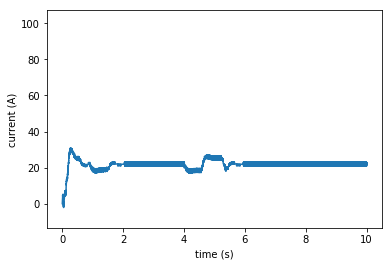

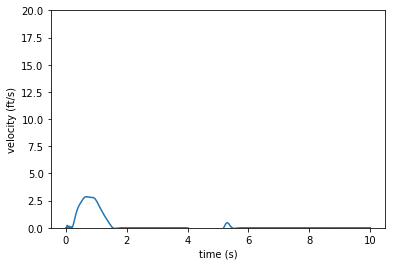

In [5]:
sim.run_lift_sim(timeout=10)
plot_position(sim)
plot_current(sim)
plot_velocity(sim)

In [52]:
HTML(animate_lift(sim).to_html5_video())

250 241 60497


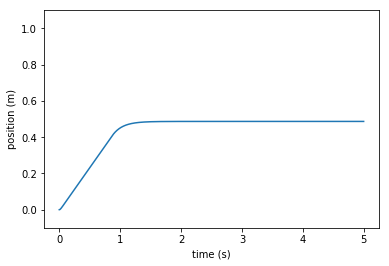

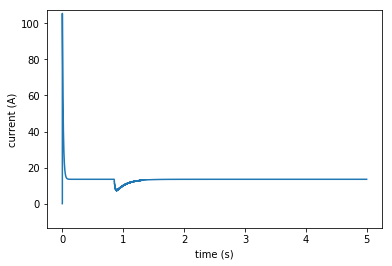

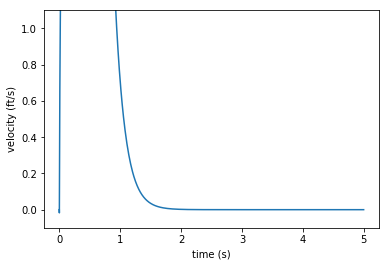

In [54]:
sim.run_climb_sim(timeout=5)
plot_position(sim)
plot_current(sim)
plot_velocity(sim)

In [55]:
HTML(animate_climb(sim).to_html5_video())

250 141 35496


In [9]:
import wpilib